# Australia Influenza Analysis 2008 - 2017

Key Questions to be asked and answered:
1. How did influenza cases change over the year? Are there similar patterns across different types of influenza viruses? 
2. Is there any difference in influenza situation across different state, gender, age group and indigenous status?
3. Can we build a relative accurate model in predicting influenza cases for the future?

In [1]:
# Get Useful Packages
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy.stats as ss
import random

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Some settings
plt.rcParams.update(plt.rcParamsDefault)
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6), dpi=300)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 500)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Useful functions (for convenience I didn't include a separate .py file)

def get_intersect_count(df, groupby_list):
    """
    This function takes a raw data frame (most time raw influenza dataset) and return a
    data frame with count of occurence within each intersection subset of a given list 
    of attributes.
    
    ::param1: the reference raw data frame
    ::param2: a list of attributes (columns) for groupby()
    """
    
    count_col = list(set(df.columns.values)-set(groupby_list))[0]  # get a random column for count()
    
    return df.groupby(groupby_list).count()[count_col].reset_index(name='Count')


def get_intersect_sum(df, groupby_list, sum_col, col_name):
    """
    This function takes a raw data frame (most time raw influenza dataset) and return a
    data frame with count of occurence within each intersection subset of a given list 
    of attributes.
    
    ::param1: the reference raw data frame
    ::param2: a list of attributes (columns) for groupby()
    ::param3: which attribute to be summed
    ::param4: new name of the summed column
    """
    
    return df.groupby(groupby_list)[sum_col].sum().reset_index(name=col_name)


def choose_palette(palette_name, color_index):
    """
    This function takes a given list of seaborn palette and choose certain colors
    in order given in the list of index for passing into seaborn plot functions (palette=xxx).
    
    ::param1: name of default palette in seaborn that can be called by
              seaborn.color_palette(palette_name)
    ::param2: the palette list index indicating which colors to be chosen
    """
    
    return [sns.color_palette(palette_name)[i] for i in color_index]


def get_monthly_prediction(train_set, pred_set, feature_cols, response_cols, model):
    """
    This function takes the training and prediction datasets and a flag on which model to use to perform a 
    six months ahead prediction for influenza cases, returning a data frame for each month's prediction
    
    ::param1: the training dataset
    ::param2: the prediction (test) dataset
    ::param3: column reference for feature input
    ::param4: column reference for prediction output
    ::param5: which model to choose: EN, KNN, DT, RF
    """
    
    # get copies of the dataset to avoid overwriting
    t_cp = train_set.copy()
    p_cp = pred_set.copy()
    
    # get the regressor for modelling
    regr_dict = {'EN': ElasticNet(),
                 'KNN': KNeighborsRegressor(),
                 'DT': DecisionTreeRegressor(),
                 'RF': RandomForestRegressor(random_state=random.seed(datetime.datetime.now()))}
    regr = regr_dict[model]
    
    # initialise result data frame
    result_df = pd.DataFrame(columns=response_cols)
    
    # get the "last month" column names
    lm_cols = [name+'_lm' for name in response_cols]
    
    # get prediction
    for i in range(6):
        regr.fit(t_cp[feature_cols], t_cp[response_cols])
        y_hat = regr.predict([p_cp.iloc[i, ][feature_cols]])
        
        # record the results
        result_df = result_df.append(pd.DataFrame(y_hat, columns=response_cols), ignore_index=True)

        # update the "last month" feature values in prediction set
        if i<5:
            p_cp.iloc[i+1, ][lm_cols] = result_df.iloc[i, ][response_cols]
    
    return result_df


def get_MAE(pred_df, true_df, response_cols):
    """
    This function helps to calculate the total Mean Absolute Error given the 
    predicted 6 months influenza cases and compare to the true recorded cases, 
    returning a single total MAE measure.
    
    ::param1: data frame of the prediction
    ::param2: data frame of true values
    ::param3: column reference
    """
    init_list = []
    for col in response_cols:
        col_abs = np.abs(pred_df[col]-true_df[col])
        init_list.append(np.sum(col_abs))
    
    return np.sum(init_list)



## Exploratory Data Analysis

In [4]:
## Read the Influenza Dataset

#influ_raw = pd.read_excel('Influenza.xlsx')
#influ_raw.to_csv('influenza.csv', index=False)

influ_raw = pd.read_csv('influenza.csv')
influ_raw.columns.values[2] = 'Age group'  # fix a small problem
influ_raw.head(5)

# Get a summary of the dataset
#profile = ProfileReport(influ_raw)
#profile.to_file(output_file='influenza_report.html')

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
0,2018-01-05,NSW,00-04,Female,not available,B
1,2018-01-05,NSW,00-04,Female,not available,B
2,2018-01-05,NSW,00-04,Male,not available,A(unsubtyped)
3,2018-01-05,NSW,20-24,Male,not available,B
4,2018-01-05,NSW,25-29,Male,not available,A(unsubtyped)


In [5]:
# As the Data Caveats mentions that the data is recorded from 1 January 2008 to 31 December 2017,
# we can just include data on 2018-01-05 in 2017-12-29
influ_raw = influ_raw.replace('2018-01-05', '2017-12-29')
influ_raw.head(5)

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
0,2017-12-29,NSW,00-04,Female,not available,B
1,2017-12-29,NSW,00-04,Female,not available,B
2,2017-12-29,NSW,00-04,Male,not available,A(unsubtyped)
3,2017-12-29,NSW,20-24,Male,not available,B
4,2017-12-29,NSW,25-29,Male,not available,A(unsubtyped)


It's obvious that each row represent one patient. In order to do quantitative analysis, we need to 
restructure the dataset and get the number of cases belong to certain intersection group of attributes.

We need to be very careful to conclude anything from the absolute count of cases in each attribute, as we need to 
take population size into consideration and make certain assumptions for specific analysis. However, there are two pieces of information we can tell immediately:

1. Type A virus is the major pathogen that causes influenza in Australia

<Figure size 3600x1800 with 0 Axes>

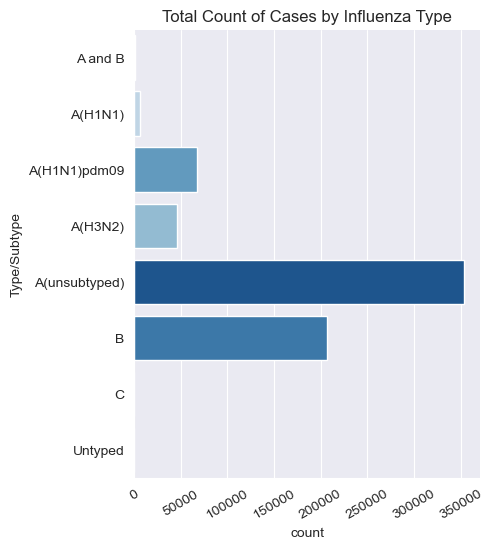

In [6]:
# Get the count plot for Influenza types
ax = sns.catplot(y='Type/Subtype', kind="count", palette=choose_palette("Blues", [0, 1, 3, 2, 5, 4, 0, 0]),
                 data=influ_raw, order=sorted(set(influ_raw['Type/Subtype'])))

ax.set_xticklabels(rotation=30)
ax.set(title='Total Count of Cases by Influenza Type')

# plt.savefig('total_count.png', dpi=300, bbox_inches='tight')
plt.show()

2. Strong seasonality in the influenza outbreaks

In [7]:
# Get two new columns of the year and month each case is recorded
influ_raw['Year'] = pd.DatetimeIndex(influ_raw['Week Ending (Friday)']).year
influ_raw['Month'] = pd.DatetimeIndex(influ_raw['Week Ending (Friday)']).month
influ_raw.head(5)

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype,Year,Month
0,2017-12-29,NSW,00-04,Female,not available,B,2017,12
1,2017-12-29,NSW,00-04,Female,not available,B,2017,12
2,2017-12-29,NSW,00-04,Male,not available,A(unsubtyped),2017,12
3,2017-12-29,NSW,20-24,Male,not available,B,2017,12
4,2017-12-29,NSW,25-29,Male,not available,A(unsubtyped),2017,12


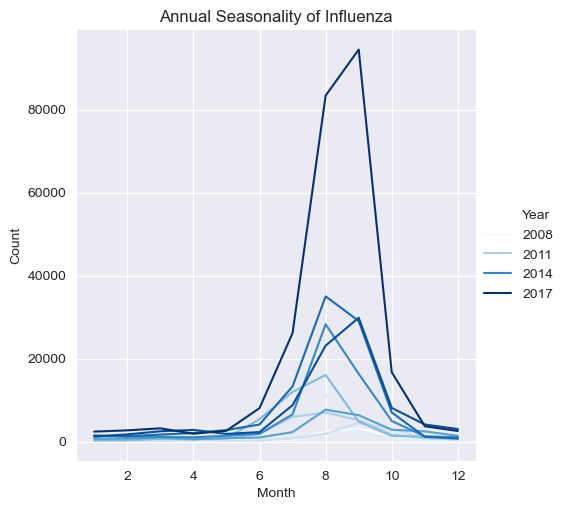

In [8]:
# Get an overall count by year and month
df_by_year_month = get_intersect_count(influ_raw, ['Year', 'Month'])

# Visualisation the cases count by time
ax = sns.relplot(x='Month', y='Count', hue='Year', kind='line', palette="Blues", data=df_by_year_month)
ax.set(title='Annual Seasonality of Influenza')
# plt.savefig('seasonality.png', dpi=300, bbox_inches='tight')
plt.show()

From the plot we can see clearly seasonality: the influenza cases start to rise in June, peak in around August and September, then abate in October forward. This matches our understanding that influenza ususally ascalates in winter.  

 ### Section 0: Get Population Data


As mentioned before, we need to take population size into consideration. Here we extract the population data one by state by gender and another by age group by gender from 2008 to 2017 from ABS. Here we make assumption that population is constant across each year (mean of each quarter's record) and age structure is the same across each state.

In [9]:
# Get raw population data across state
pop_state = pd.read_csv('state_pop.csv')

# Get a year column
pop_state['Year'] = pd.DatetimeIndex(pop_state['Date']).year

pop_state.head(5)

,Gender,Date,NSW,Vic,Qld,SA,WA,Tas,NT,Year
0,Male,2008-03-01,3432731,2592080,2092307,782440,1086540,246319,113502,2008
1,Male,2008-06-01,3445097,2603921,2107284,784833,1094894,246919,114771,2008
2,Male,2008-09-01,3460648,2619884,2121849,787629,1105053,247761,115630,2008
3,Male,2008-12-01,3476199,2633317,2135996,789696,1113633,248714,116223,2008
4,Male,2009-03-01,3492115,2650782,2151248,793076,1123379,249633,117033,2009


In [10]:
# Get raw population data across age group
pop_age = pd.read_csv('age_pop.csv')
pop_age.head(5)

,Sex,Age group,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Male,00-04,707613,732046,746322,748527,764555,779375,784460,797038,807893,811093
1,Male,05-09,691453,696353,697910,712205,729260,747686,764395,788647,804219,814019
2,Male,10-14,720197,720836,710019,711543,713342,716616,721630,724624,735448,757231
3,Male,15-19,762469,772070,749321,746599,750636,754838,758211,752497,755575,760068
4,Male,20-24,798505,830048,824068,823470,829036,836701,845159,856374,864974,878560


In [11]:
# Alter the data structure of pop_state
pop_state2 = pop_state.melt(id_vars=['Gender', 'Year', 'Date'], var_name='State', value_name='Population')

# Get population by gender by state across years
pop_by_gender_state = pop_state2.groupby(['Gender', 'Year', 'State'])['Population'].mean().reset_index(name='Population')
pop_by_gender_state.columns.values[0] = 'Sex'  # match influ_raw for possible data frame merge
pop_by_gender_state.head(10)

,Sex,Year,State,Population
0,Female,2008,NSW,3505717.50
1,Female,2008,NT,105412.50
2,Female,2008,Qld,2119272.50
3,Female,2008,SA,805020.00
4,Female,2008,Tas,252060.75
5,Female,2008,Vic,2660001.75
6,Female,2008,WA,1081910.50
7,Female,2009,NSW,3557349.25
8,Female,2009,NT,107834.00
9,Female,2009,Qld,2170858.25


In [12]:
# Alter the data structure of pop_age and get population by gender by age group across years
pop_by_gender_age = pop_age.melt(id_vars=['Sex', 'Age group'], var_name='Year', value_name='Population')
pop_by_gender_age['Year'] = pop_by_gender_age['Year'].astype(np.int64)
pop_by_gender_age.head(10)

,Sex,Age group,Year,Population
0,Male,00-04,2008,707613
1,Male,05-09,2008,691453
2,Male,10-14,2008,720197
3,Male,15-19,2008,762469
4,Male,20-24,2008,798505
5,Male,25-29,2008,772812
6,Male,30-34,2008,739221
7,Male,35-39,2008,795205
8,Male,40-44,2008,753725
9,Male,45-49,2008,768551


### Section 1: Time and Virus Type Analysis

Firstly let's check whether there is evident trend in the number of influenza cases across years.

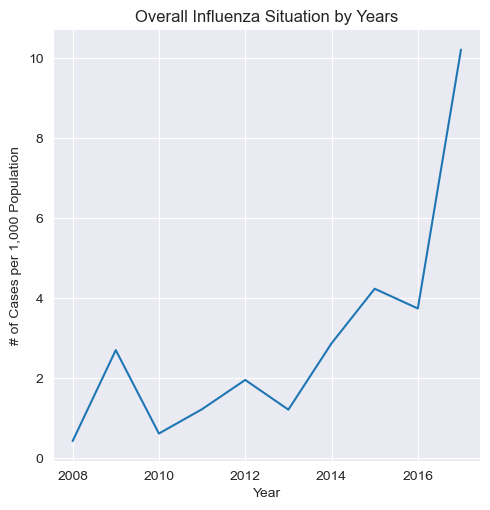

In [13]:
# Get an overall cases count by year
influ_by_year = get_intersect_count(influ_raw, ['Year'])

# Get the total population by year
pop_by_year = get_intersect_sum(pop_by_gender_state, ['Year'], 'Population', 'Total_Population')

# Calculate the number of cases per 1000 population
influ_by_year['Case_Per_1000'] = influ_by_year['Count']/pop_by_year['Total_Population']*1000

# Visualisation the cases count by year
ax = sns.relplot(x='Year', y='Case_Per_1000', kind='line', palette="Blues", data=influ_by_year)
ax.set(xlabel='Year', ylabel='# of Cases per 1,000 Population', title='Overall Influenza Situation by Years')

# plt.savefig('overall_trend.png', dpi=300, bbox_inches='tight')
plt.show()

There are 3 things to notice here:
1. There is an overall increasing trend in influenza cases in Australia. However, we cannot just simply tell the absolute severity based on this graph. This is because the dataset does not include information such as the changes in testing policies, the periodic awareness campaigns, the use of less invasive and more sensitive diagnostic tests and so on. These factors can also influence the diagnosed cases annually.
 
2. We can see some weak cyclic trend as well. From 2010 to 2016, the cases increased by 2 years then drop the next year after. One possible explanation is human intervention (e.g. R&D for vaccines, level of attention) has a 2 year cycle but the each response is only effective for 1 year period.
 
3. There are much larger cases in 2015 to 2017 and an absurd jump of cases in 2017 (2.5 times larger than 2015 per 1,000 population)

In [14]:
# Check what happened based on different types of virus
influ_by_year_type = get_intersect_count(influ_raw, ['Year', 'Type/Subtype'])
influ_by_year_type = pd.merge(influ_by_year_type, pop_by_year, on='Year')
influ_by_year_type['Case_Per_1000'] = influ_by_year_type['Count']/influ_by_year_type['Total_Population']*1000

influ_by_year_type.pivot('Year', 'Type/Subtype', 'Case_Per_1000')

Type/Subtype,A and B,A(H1N1),A(H1N1)pdm09,A(H3N2),A(unsubtyped),B,C,Untyped
Year,,,,,,,,
2008,0.000286,0.008970,NaN,0.017368,0.159984,0.233701,0.000095,0.004533
2009,0.000608,0.303486,1.436130,0.078912,0.856009,0.021611,NaN,0.005847
2010,0.002350,NaN,0.346225,0.024882,0.181360,0.060085,NaN,0.000599
2011,0.002861,NaN,0.320546,0.090605,0.476641,0.329175,0.000091,0.004496
2012,0.002991,NaN,0.013614,0.328876,1.146646,0.463854,0.000402,0.000045
2013,0.003116,NaN,0.173709,0.071143,0.517001,0.447658,NaN,0.000219
2014,0.004021,NaN,0.293491,0.238667,1.991181,0.343170,0.000562,0.000821
2015,0.008865,NaN,0.096449,0.276051,1.290239,2.566116,0.000043,0.000043
2016,0.003566,NaN,0.224354,0.398282,2.713934,0.402478,0.000168,0.001259


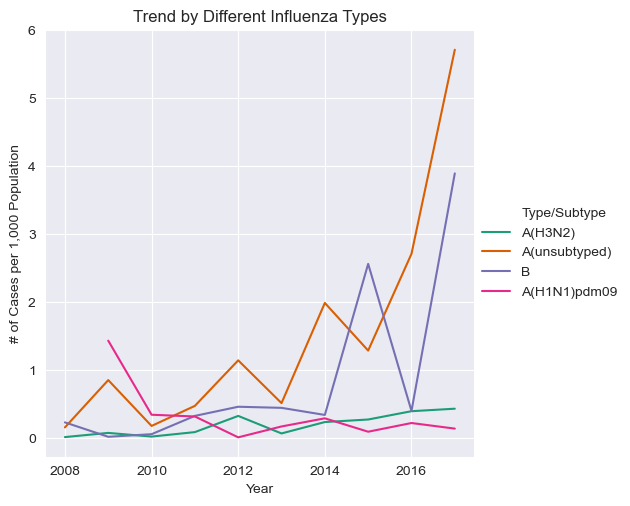

In [15]:
# Plot for the major virus: A(H1N1)pdm09, A(H3N2), A(unsubtyped) & B
ax = sns.relplot(x='Year', y='Case_Per_1000', hue='Type/Subtype', kind='line', palette="Dark2", 
         data=influ_by_year_type[influ_by_year_type['Type/Subtype'].isin(['A(H1N1)pdm09', 'A(H3N2)', 'A(unsubtyped)', 'B'])])

ax.set(xlabel='Year', ylabel='# of Cases per 1,000 Population', title='Trend by Different Influenza Types')

# plt.savefig('trend_type_1.png', dpi=300, bbox_inches='tight')
plt.show()

From this plot, we can firstly see that the trend in the overall influenza situation is very similar to the general type A influenza, except for the 2009 H1N1 pandemic and an outbreak of type B influenza in 2015.

The other interesting finding is, if there is an obvious new historical peak of certain type of influenza, it is very likely that the cases for that type drops the next year. This is intuitive as people get more alerted in a peak and take actions to prevent so that the situation abates next year. However, the only exception is still 2017, where type A influenza worsened even more after a peak in 2016. The dreaded H3N2 virus is also the worst in 2017 while escalating since 2013.

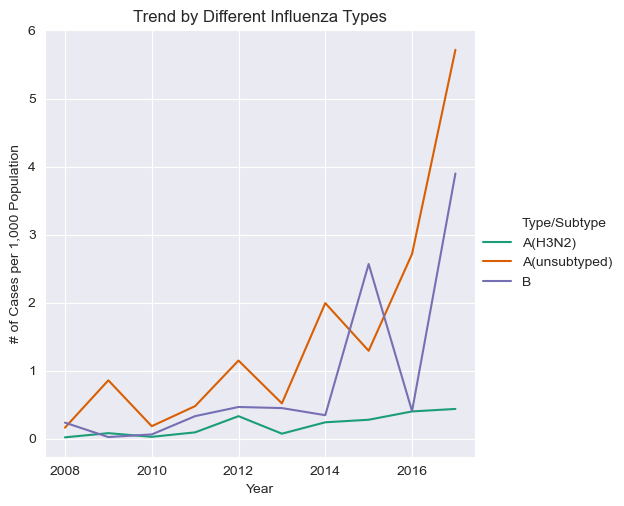

In [16]:
# Take out H1N1 to get a more clear graph
ax = sns.relplot(x='Year', y='Case_Per_1000', hue='Type/Subtype', kind='line', palette="Dark2", 
         data=influ_by_year_type[influ_by_year_type['Type/Subtype'].isin(['A(H3N2)', 'A(unsubtyped)', 'B'])])

ax.set(xlabel='Year', ylabel='# of Cases per 1,000 Population', title='Trend by Different Influenza Types')

# plt.savefig('trend_type_2.png', dpi=300, bbox_inches='tight')
plt.show()

### Section 2: Gender and Age Group Analysis

First we want to check whether influenza (and different types of influenza) has different severity across gender. (we do not include unknown and X as there are too few samples)

In [17]:
# Remember to consider population size
influ_by_year_gender = get_intersect_count(influ_raw[influ_raw.Sex.isin(['Male', 'Female'])], ['Year', 'Sex'])
pop_by_year_gender = get_intersect_sum(pop_by_gender_state, ['Year', 'Sex'], 'Population', 'Population_by_Sex')

influ_by_year_gender = pd.merge(influ_by_year_gender, pop_by_year_gender, on=['Year', 'Sex'])
influ_by_year_gender['Case_Per_1000'] = influ_by_year_gender['Count']/influ_by_year_gender['Population_by_Sex']*1000
influ_by_year_gender

,Year,Sex,Count,Population_by_Sex,Case_Per_1000
0,2008,Female,4633,10529395.50,0.440006
1,2008,Male,4265,10428967.50,0.408957
2,2009,Female,29173,10734243.75,2.717751
3,2009,Male,28247,10644040.00,2.653786
4,2010,Female,7018,10899880.50,0.643860
5,2010,Male,6278,10802794.75,0.581146
6,2011,Female,14242,11061663.25,1.287510
7,2011,Male,12689,10956994.00,1.158073
8,2012,Female,23504,11255319.50,2.088257
9,2012,Male,20298,11148288.50,1.820728


In [18]:
# Perform a paired-sample t-test for male and female on the number of cases per 1000 population
ss.ttest_rel(influ_by_year_gender[influ_by_year_gender.Sex=='Male']['Case_Per_1000'],
             influ_by_year_gender[influ_by_year_gender.Sex=='Female']['Case_Per_1000'])

Ttest_relResult(statistic=-2.2924926279776976, pvalue=0.04758024143592689)

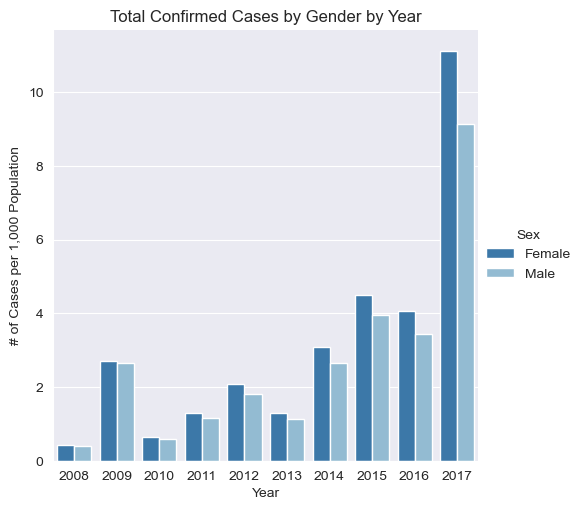

In [19]:
# Plot the graph to visualise the pattern
ax = sns.catplot(x='Year', y='Case_Per_1000', hue='Sex', kind='bar', palette=choose_palette('Blues', [4, 2]),
                 data=influ_by_year_gender)

ax.set(xlabel='Year', ylabel='# of Cases per 1,000 Population', title='Total Confirmed Cases by Gender by Year')
# plt.savefig('gender_overall.png', dpi=300, bbox_inches='tight')
plt.show()

The test result and graph shows that there is an overall difference in recorded influenza situation between males and females. In fact, females have constantly more cases confirmed across years. However, we still cannot simply say that females are more vulnerable to influenza —— females may care more about their health and are more likely to seek medical support so that more cases are recorded. To get an accurate conclusion we need to do some survey to check whether there is this kind of drivers causing the differences by gender.

Next we want to check whether influenza affects different age groups to different extent. Note that it's better to separate males and females because they can have different age strucuture (especially at older ages).

In [20]:
# Similar data construction idea as before
influ_by_year_gender_age = get_intersect_count(influ_raw[(influ_raw.Sex.isin(['Male', 'Female'])) &
                                                         (influ_raw['Age group']!='Unknown')],
                                               ['Year', 'Sex', 'Age group'])

influ_by_year_gender_age = pd.merge(influ_by_year_gender_age, pop_by_gender_age, on=['Year', 'Sex', 'Age group'])
influ_by_year_gender_age['Case_Per_1000'] = influ_by_year_gender_age['Count']/influ_by_year_gender_age['Population']*1000

influ_by_year_gender_age.head(5)

,Year,Sex,Age group,Count,Population,Case_Per_1000
0,2008,Female,00-04,634,670615,0.945401
1,2008,Female,05-09,322,657940,0.489406
2,2008,Female,10-14,293,682686,0.429187
3,2008,Female,15-19,362,717205,0.504737
4,2008,Female,20-24,333,755900,0.440534


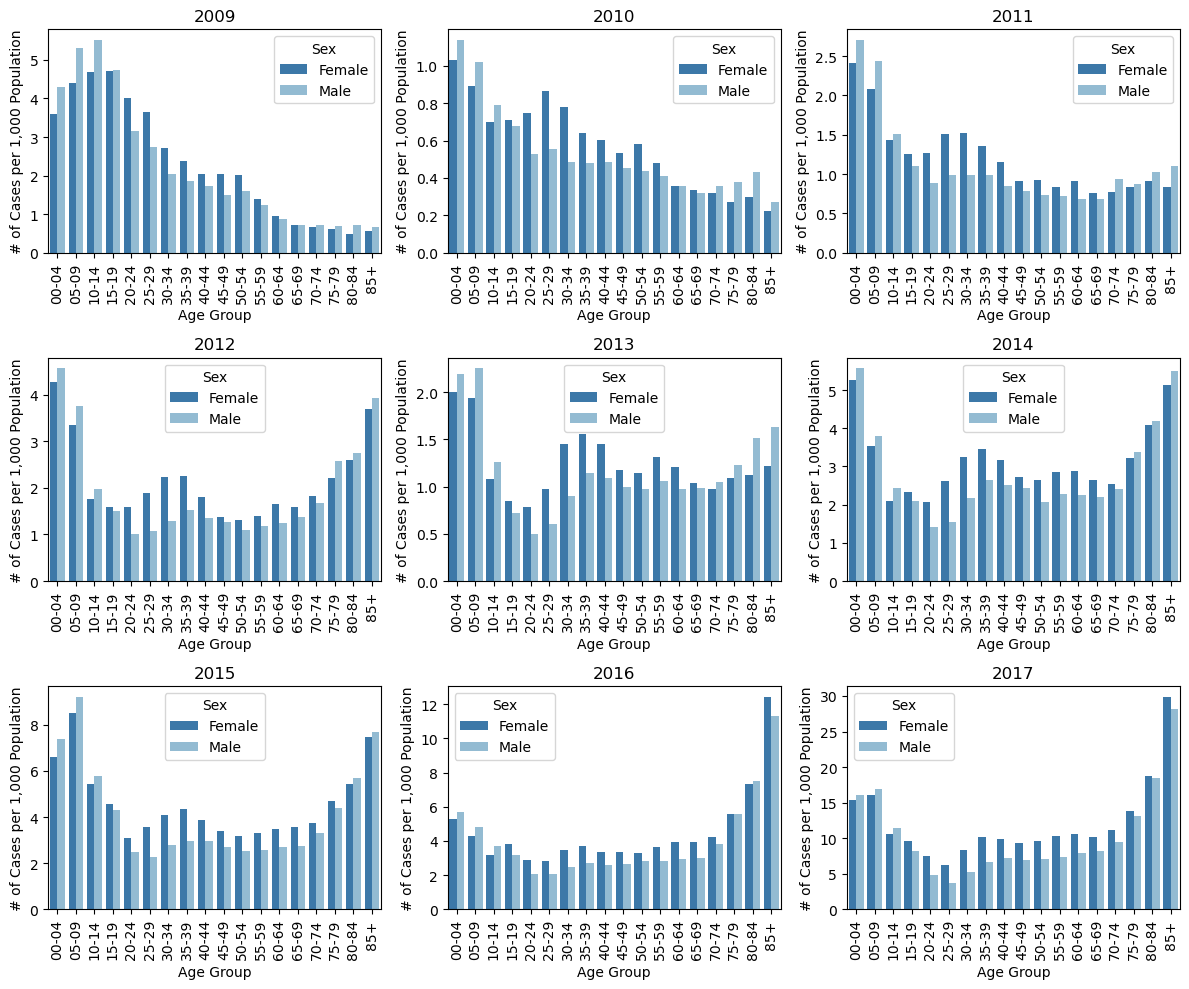

In [21]:
# Check the influenza situation from 2009 to 2017
plt.rcParams.update(plt.rcParamsDefault)
f = plt.figure(figsize=(12, 10))
gs = f.add_gridspec(3, 3)

for i, year in enumerate(range(2009, 2018)):
    ax = f.add_subplot(gs[i//3, i%3])
    sns.barplot(x='Age group', y='Case_Per_1000', hue='Sex', palette=choose_palette('Blues', [4, 2]),
                data=influ_by_year_gender_age[influ_by_year_gender_age.Year==year])

    ax.set(xlabel='Age Group', ylabel='# of Cases per 1,000 Population', title=str(year))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

f.tight_layout() 
plt.show()

There are  interesting insights that can be explored when adding in age groups. We will discuss them one by one.

1. Elder and young populations are the major victim of influenza, although they are also more likely to seek medical help. However, elder population are getting more vulnerable over the years since 2009 whereas young population are more protected. (H1N1 did not influence elder poppulation severely)

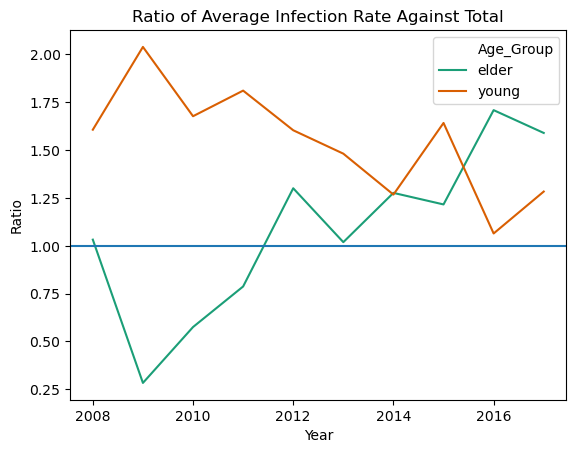

In [22]:
# Calculate the ratio between average infection rates (cases per 1,000 population) of elder population (70+), 
# young population (14-) against total population across years
influ_by_year_age = get_intersect_sum(influ_by_year_gender_age, ['Year', 'Age group'], 'Case_Per_1000', 'Case_Per_1000')

infect_ratio_elder = []
infect_ratio_young = []

for year in range(2008, 2018):
    df_year = influ_by_year_age[influ_by_year_age.Year==year]
    df_elder = df_year[df_year['Age group'].isin(['70-74', '75-79', '80-84', '85+'])]
    df_young = df_year[df_year['Age group'].isin(['00-04', '05-09', '10-14'])]
    
    infect_ratio_elder.append(np.mean(df_elder['Case_Per_1000']) / np.mean(df_year['Case_Per_1000']))
    infect_ratio_young.append(np.mean(df_young['Case_Per_1000']) / np.mean(df_year['Case_Per_1000']))
    
# Visualise the ratios
infect_df = pd.DataFrame()
infect_df['Year'] = list(range(2008, 2018))*2
infect_df['Age_Group'] = ['elder']*10 + ['young']*10
infect_df['Ratio'] = infect_ratio_elder + infect_ratio_young

ax = sns.lineplot(x='Year', y='Ratio', hue='Age_Group', palette="Dark2", data=infect_df)
ax.axhline(1.0)
ax.set(xlabel='Year', ylabel='Ratio', title='Ratio of Average Infection Rate Against Total')

# plt.savefig('young_and_elder.png', dpi=300, bbox_inches='tight')
plt.show()

2. Males are in general more vulnerable than females in the young population. For elder population it becomes the opposite since 2015.

We are also much safer to draw this conclusion as young and elder populations are very likely to seek medical support so that this perticular confounding issue is well handled.

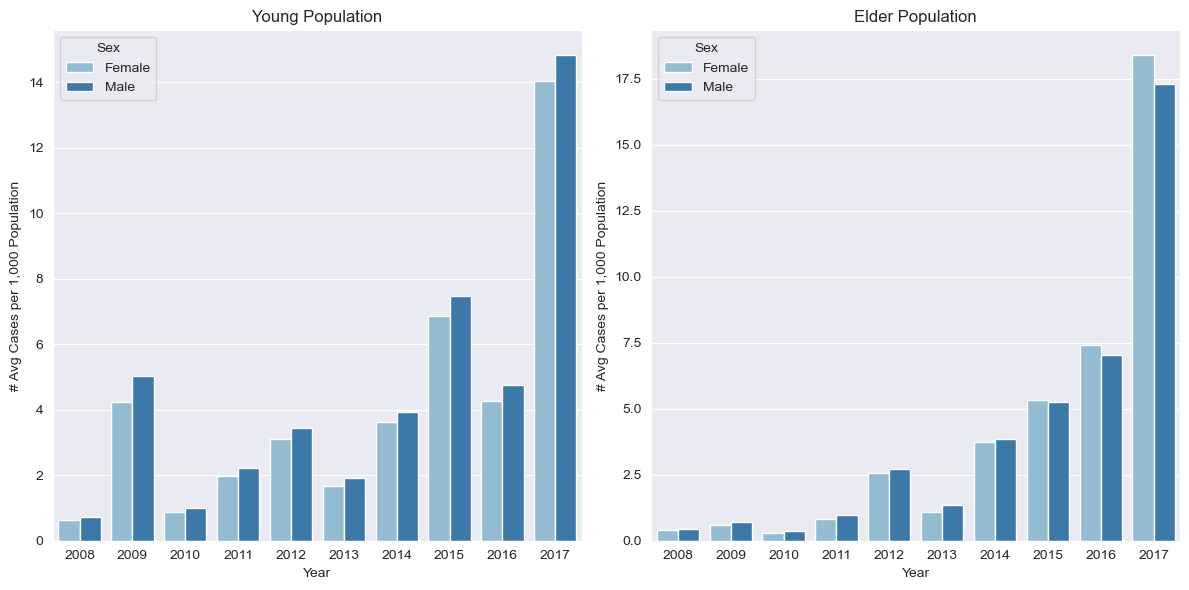

In [23]:
# Calculate average infection rate of elder and young population between male and female
infect_df_elder = influ_by_year_gender_age[influ_by_year_gender_age['Age group'].isin(['70-74', '75-79', '80-84', '85+'])]
infect_df_young = influ_by_year_gender_age[influ_by_year_gender_age['Age group'].isin(['00-04', '05-09', '10-14'])]

infect_df_elder = infect_df_elder.groupby(['Year', 'Sex']).mean()['Case_Per_1000'].reset_index(name='Avg_Case_Per_1000')
infect_df_young = infect_df_young.groupby(['Year', 'Sex']).mean()['Case_Per_1000'].reset_index(name='Avg_Case_Per_1000')

# Visualise the pattern
plt.rcParams.update(plt.rcParamsDefault)
sns.set_style('darkgrid')
f = plt.figure(figsize=(12, 6))
gs = f.add_gridspec(1, 2)

ax = f.add_subplot(gs[0, 0])
sns.barplot(x='Year', y='Avg_Case_Per_1000', hue='Sex', palette=choose_palette('Blues', [2, 4]),
            data=infect_df_young)
ax.set(xlabel='Year', ylabel='# Avg Cases per 1,000 Population', title='Young Population')
ax.set_xticklabels(ax.get_xticklabels())

ax = f.add_subplot(gs[0, 1])
sns.barplot(x='Year', y='Avg_Case_Per_1000', hue='Sex', palette=choose_palette('Blues', [2, 4]),
            data=infect_df_elder)
ax.set(xlabel='Year', ylabel='# Avg Cases per 1,000 Population', title='Elder Population')
ax.set_xticklabels(ax.get_xticklabels())

f.tight_layout() 
# plt.savefig('gender_age.png', dpi=300, bbox_inches='tight')
plt.show()

The following t-tests sugggest the same idea.

In [24]:
# Perform a paired-sample t-test for male and female on the number of cases per 1000 population
ss.ttest_rel(infect_df_elder[infect_df_elder.Sex=='Male']['Avg_Case_Per_1000'],
             infect_df_elder[infect_df_elder.Sex=='Female']['Avg_Case_Per_1000'])

Ttest_relResult(statistic=-0.44699681842422745, pvalue=0.665440396503191)

In [25]:
# Perform a paired-sample t-test for male and female on the number of cases per 1000 population
ss.ttest_rel(infect_df_young[infect_df_young.Sex=='Male']['Avg_Case_Per_1000'],
             infect_df_young[infect_df_young.Sex=='Female']['Avg_Case_Per_1000'])

Ttest_relResult(statistic=4.7418850005173265, pvalue=0.0010561368169936301)

3. There is potential difference in influenza situation within in gender and age groups across different types of influenza. However, due to time constraint this will be remained as an extended task.

### Section 3: State Analysis

For state we will not separate further on gender or age group. We will just assume the difference caused by gender and age is very similar across all states.

In [26]:
# Get cases per 1000 population in each state
influ_by_year_state = get_intersect_count(influ_raw, ['Year', 'State'])
pop_by_state = get_intersect_sum(pop_by_gender_state, ['Year', 'State'], 'Population', 'State_Population')

influ_by_year_state = pd.merge(influ_by_year_state, pop_by_state, on=['Year', 'State'])
influ_by_year_state['Case_Per_1000'] = influ_by_year_state['Count']/influ_by_year_state['State_Population']*1000
influ_by_year_state.head(7)

,Year,State,Count,State_Population,Case_Per_1000
0,2008,NSW,1840,6959386.25,0.264391
1,2008,NT,200,220444.00,0.907260
2,2008,Qld,3690,4233631.50,0.871592
3,2008,SA,473,1591169.50,0.297266
4,2008,Tas,385,499489.00,0.770788
5,2008,Vic,1299,5272302.25,0.246382
6,2008,WA,1019,2181940.50,0.467015


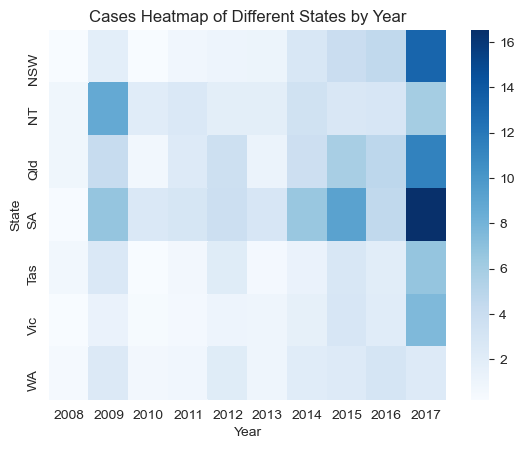

In [27]:
# Visualise patterns across state
ax = sns.heatmap(influ_by_year_state.pivot('State', 'Year', 'Case_Per_1000'), cmap="Blues")
ax.set(title='Cases Heatmap of Different States by Year')
# plt.savefig('state.png', dpi=300, bbox_inches='tight')
plt.show()

From the heatmap we can actually see that SA and Qld generally suffered most from influenza seasons and NSW was getting more affected compared to other states. It's an interesting finding but we do need more research to find out possible reasons. (for example, SA generally suffers most which may due to a relatively low temperature in winter)

Also we would like to do a rough check of in which state each influenza season started by checking the number of cases recorded in May. Note that we don't standardise by population for this check as at the beginning it will just be cluster infection.

In [28]:
# Get the number of cases in each May over all States
influ_by_year_June_state = get_intersect_count(influ_raw[influ_raw.Month==5], ['Year', 'State'])
influ_by_year_June_state.pivot('Year', 'State', 'Count')

State,NSW,NT,Qld,SA,Tas,Vic,WA
Year,,,,,,,
2008,90,2,106,6,6,22,34
2009,412,31,256,219,14,884,85
2010,53,1,72,12,5,40,25
2011,151,4,275,147,27,105,23
2012,191,34,238,94,4,97,119
2013,166,11,249,148,2,164,77
2014,272,12,520,137,21,294,140
2015,468,17,841,537,37,496,361
2016,585,16,611,121,17,252,234


Here we can see that except 2009 and 2017, highest case count in May all comes from Queensland. But again we need more research to find out possible reasons.

For indigenous status, as many of the cases recorded are unsure status, we will not analyse further on that.

## Predictive Model for Influenza

Next we want to try finding a relatively accurate predictive model for forecasting future influenza cases. However, there are already issues we can see with the given dataset in terms of prediction: 

1. Some attributes such as Sex, Age group and State will not directly help to forecast the total number of influenza cases so we have very limit amount of data to use.
2. The prediction will be largely influenced by outbreaks of certain type of influenza or pandemic, such as 2009 and 2017.

To reduce the influence of these issues, here are some treatments:

1. Create new features (future engineering) based on our previous insights.
2. The influenza cases have a rather stable pattern from 2010 to 2016, so we will mainly use this period of data for modelling. The data in 2016 will be used as both validation set and testing set to check the prediction power on general situations. Then we check the precision of prediction on 2017 to see whether the model can address outbreaks of influenza.

Also from previous analysis, it would be better to predict the cases by different types of influenza as they appear different highs and lows across years. Here the influenza is summarised into 4 groups: A(unsubtyped), B, A(H3N2), and Other (which include all else and untyped ones). Moreoever, we again use cases per 1,000,000 population as the measure instead of absolute case count.

### Feature Engineering

In [29]:
# We are not including State, Sex, Age group and Indigenous status in the model
influ_model = get_intersect_count(influ_raw, ['Year', 'Month', 'Type/Subtype'])

# Restructure the dataset
influ_model = influ_model.pivot(['Year', 'Month'], 'Type/Subtype', 'Count').reset_index()
influ_model = influ_model.fillna(0)
influ_model.head(5)

Type/Subtype,Year,Month,A and B,A(H1N1),A(H1N1)pdm09,A(H3N2),A(unsubtyped),B,C,Untyped
0,2008,1,0.0,3.0,0.0,3.0,49.0,34.0,0.0,6.0
1,2008,2,0.0,3.0,0.0,6.0,79.0,48.0,0.0,11.0
2,2008,3,0.0,1.0,0.0,6.0,77.0,54.0,0.0,16.0
3,2008,4,0.0,1.0,0.0,3.0,85.0,63.0,0.0,5.0
4,2008,5,0.0,0.0,0.0,15.0,150.0,98.0,0.0,3.0


In [30]:
# Aggregate some influenza types into 'Other'
influ_model['Other'] = influ_model.loc[:, ['A and B', 'A(H1N1)', 'A(H1N1)pdm09', 'C', 'Untyped']].sum(axis=1)

In [31]:
# Drop off the grouped types
influ_model = influ_model.drop(['A and B', 'A(H1N1)', 'A(H1N1)pdm09', 'C', 'Untyped'], axis=1)

In [32]:
# Include each years population and get the cases per 1,000 population measurements
flu_types = influ_model.columns.values[2:]
influ_model = pd.merge(influ_model, pop_by_year, on='Year')

for ft in flu_types:
    influ_model[ft+'_Per_1M'] = influ_model[ft]/influ_model['Total_Population']*1000000

In [33]:
# Include the influenza infection rate of the previous month
flu_types_1M = influ_model.columns.values[-4:]

for ftm in flu_types_1M:
    influ_model[ftm+'_lm'] = [0] + list(influ_model[ftm])[:(influ_model.shape[0]-1)]

In [34]:
# Include whether there was a historical high infection rate in the last year for each type of influenza
peak_df = pd.DataFrame()
peak_df['Year'] = list(range(2008, 2018))

for ft in flu_types:
    ft_bool = [0, 0]  # store 0 for 2008 and 2009 as we don't know 07 and 08 were peaks (they will not be used anyway)
    
    for year in range(2010, 2018):
        last_year_total = np.sum(influ_model[influ_model.Year==(year-1)][ft+'_Per_1M'])
        previous_max = np.max([np.sum(influ_model[influ_model.Year==py][ft+'_Per_1M']) for py in range(2008, year-1)])
        
        if last_year_total>previous_max:
            ft_bool.append(1)
        else:
            ft_bool.append(0)
    
    peak_df[ft+'_peak_ly'] = ft_bool

In [35]:
# Merge the upper info into influ_model
influ_model = pd.merge(influ_model, peak_df, on='Year')

In [36]:
# Include the influenza measure from the same month last year
for ftm in flu_types_1M:
    infect_ly = [0]*12  # initialise for 2008 (will not be included in training model anyway)

    for year in range(2009, 2018):
        infect_ly += list(influ_model[influ_model.Year==(year-1)][ftm])
    
    influ_model[ftm+'_ly'] = infect_ly

In [37]:
# One-hot Encoding for the months
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(influ_model[['Month']]).toarray())

# merge with influ_model
influ_model = influ_model.join(enc_df)

In [38]:
# Clean up useless columns
useless_cols = ['Month', 'Total_Population'] + list(flu_types)
df_model = influ_model.copy()
df_model = df_model.drop(useless_cols, axis=1)

df_model.head(10)

,Year,A(H3N2)_Per_1M,A(unsubtyped)_Per_1M,B_Per_1M,Other_Per_1M,A(H3N2)_Per_1M_lm,A(unsubtyped)_Per_1M_lm,B_Per_1M_lm,Other_Per_1M_lm,A(H3N2)_peak_ly,A(unsubtyped)_peak_ly,B_peak_ly,Other_peak_ly,A(H3N2)_Per_1M_ly,A(unsubtyped)_Per_1M_ly,B_Per_1M_ly,Other_Per_1M_ly,0,1,2,3,4,5,6,7,8,9,10,11
0,2008,0.143141,2.337969,1.622264,0.429423,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2008,0.286282,3.769378,2.290255,0.667991,0.143141,2.337969,1.622264,0.429423,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2008,0.286282,3.673951,2.576537,0.811132,0.286282,3.769378,2.290255,0.667991,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2008,0.143141,4.055660,3.005960,0.286282,0.286282,3.673951,2.576537,0.811132,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2008,0.715705,7.157048,4.675938,0.143141,0.143141,4.055660,3.005960,0.286282,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2008,0.620277,6.489056,4.532797,0.238568,0.715705,7.157048,4.675938,0.143141,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2008,1.240555,8.970166,11.880699,1.335982,0.620277,6.489056,4.532797,0.238568,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,2008,4.771365,32.731564,77.248400,2.528823,1.240555,8.970166,11.880699,1.335982,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,2008,5.725638,46.186813,92.373627,4.819079,4.771365,32.731564,77.248400,2.528823,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,2008,2.576537,28.341908,26.624217,2.147114,5.725638,46.186813,92.373627,4.819079,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Model Fitting & Selection

There are four models we would like to try for predicting 6 months of influenza cases per 1 million population:
1. Elastic Net
2. KNN for Regression
3. Decision Tree for Regression
4. Random Forest for Regression

Note that due to the time series nature, we can use the prediction of the previous month as input for prediction of the current month. Therefore we need to predict the month one by one. Also there is no point doing random train-test split due to time effect.

Moreover, we do not want to include year as a feature because we try to avoid the extent of overfitting on any particular year (just use Year as index).

Firstly we try to use data from 2010 onwards to predict influenza cases for 2016 June to November.

In [39]:
# Get response variable columns and feature columns
resp_cols = flu_types_1M
feat_cols = list(set(df_model.columns.values)-set(resp_cols))
feat_cols.remove('Year')

In [40]:
# Get training and validation (2016 Jun-Dec) set
df_train = df_model.iloc[24:101, ].reset_index(drop=True)  # from 2010 Jan to 2016 May
df_vldtn = df_model.iloc[101:107, ].reset_index(drop=True)  # from 2016 Jun to 2016 Nov

In [41]:
# A function has been provided at the beginning to do predictions one by one across months,
# use that function to try the four algorithms on predicting 2016 data
EN_pred_2016 = get_monthly_prediction(df_train, df_vldtn, feat_cols, resp_cols, 'EN')
KNN_pred_2016 = get_monthly_prediction(df_train, df_vldtn, feat_cols, resp_cols, 'KNN')
DT_pred_2016 = get_monthly_prediction(df_train, df_vldtn, feat_cols, resp_cols, 'DT')
RF_pred_2016 = get_monthly_prediction(df_train, df_vldtn, feat_cols, resp_cols, 'RF')

In [42]:
# Print out the total MAE for each model prediction
EN_MAE_2016 = get_MAE(EN_pred_2016, df_vldtn[resp_cols], resp_cols)
KNN_MAE_2016 = get_MAE(KNN_pred_2016, df_vldtn[resp_cols], resp_cols)
DT_MAE_2016 = get_MAE(DT_pred_2016, df_vldtn[resp_cols], resp_cols)
RF_MAE_2016 = get_MAE(RF_pred_2016, df_vldtn[resp_cols], resp_cols)

In [43]:
print(f'MAE for EN: {EN_MAE_2016}')
print(f'MAE for KNN: {KNN_MAE_2016}')
print(f'MAE for DT: {DT_MAE_2016}')
print(f'MAE for RF: {RF_MAE_2016}')

MAE for EN: 8016.034375529624
MAE for KNN: 1697.6928550093958
MAE for DT: 4289.775744238209
MAE for RF: 2288.0319904225494


We can try different times to get an average MAE of random forest but it is not going to beat KNN.
Also we don't do hyperparameter tuning here. The reason is we don't want to overfit on any year's data.

In [44]:
KNN_pred_2016

,A(H3N2)_Per_1M,A(unsubtyped)_Per_1M,B_Per_1M,Other_Per_1M
0,21.196373,96.091638,27.634407,20.307116
1,50.880841,278.100914,63.558228,38.222000
2,51.889905,319.790841,108.109098,50.902069
3,58.737643,423.175034,96.594968,35.933163
4,58.737643,423.175034,96.594968,35.933163
5,28.004077,93.228856,30.436213,3.074190


In [45]:
# Do a rough residual analysis
KNN_residual = pd.DataFrame()
for col in resp_cols:
    KNN_residual[col] = KNN_pred_2016[col] - df_vldtn[col]
KNN_residual

,A(H3N2)_Per_1M,A(unsubtyped)_Per_1M,B_Per_1M,Other_Per_1M
0,10.289123,44.198298,12.238404,2.939417
1,-17.163620,61.004682,25.676508,-6.497726
2,-88.478016,-397.193062,44.888998,1.903344
3,-45.804156,-598.163103,-2.535157,9.252351
4,28.029538,163.121016,51.875241,31.654165
5,16.761219,-31.281601,-4.886498,1.857612


We can see that the key prediction error comes from underfitting both Type A influenza during the August and September peaks.

In [46]:
# Try use KNN to predict the winter months (June to November) in 2017
df_train_2017 = df_model.iloc[24:113, ].reset_index(drop=True)  # from 2010 Jan to 2017 May
df_test = df_model.iloc[113:119, ].reset_index(drop=True)  # 2017 Jun to Nov
KNN_pred_2017 = get_monthly_prediction(df_train_2017, df_test, feat_cols, resp_cols, 'KNN')
KNN_MAE_2017 = get_MAE(KNN_pred_2017, df_test[resp_cols], resp_cols)
print(f'MAE for KNN in 2017: {KNN_MAE_2017}')

MAE for KNN in 2017: 7031.31751139428


In [47]:
# Do a rough residual analysis on 2017 prediction
KNN_residual_2017 = pd.DataFrame()
for col in resp_cols:
    KNN_residual_2017[col] = KNN_pred_2017[col] - df_test[col]
KNN_residual_2017

,A(H3N2)_Per_1M,A(unsubtyped)_Per_1M,B_Per_1M,Other_Per_1M
0,-1.278710,-118.876724,-89.743504,-5.118084
1,-8.302902,-391.548035,-161.325472,13.257015
2,-118.313145,-1841.704316,-851.806739,-35.602362
3,-56.025760,-1523.140488,-1519.322043,-32.726086
4,13.917244,20.143032,-175.071142,11.224890
5,2.776238,4.017013,-24.758098,11.318470


The underfitting is actually expected as influenza situation escalate largely in 2017. If we now check Random Forest on 2017 prediction it's actually better than KNN.

In [48]:
# Try to compare with random forest to predict the winter months (June to November) in 2017
RF_pred_2017 = get_monthly_prediction(df_train_2017, df_test, feat_cols, resp_cols, 'RF')
RF_MAE_2017 = get_MAE(RF_pred_2017, df_test[resp_cols], resp_cols)
print(f'MAE for RF in 2017: {RF_MAE_2017}')

MAE for RF in 2017: 6406.336477718005


### Limitations

Some limitations have already been discussed during the analysis. To summarise, it is very hard to get an accurate prediction model of influenza, mainly due to sudden outbreaks of certain type of viruses which can not be predicted purely based on historical data. Secondly, our data is also missing other drivers such as the R&D and distribution of vaccines, public education on epidemic prevention, population density and so on. Therefore, the next step of this analysis will be looking into more detailed data in order to generate more accurate insights and predictions. However, such pandemic like COVID-19 is surely a difficulty in prediction.